# Imputação de Dados - Wind Data Analysis

## Objetivo
Implementar estratégia de imputação para o dataset `wind_data.csv` com múltiplas variáveis (velocidade, vento vertical e direção) em diferentes alturas.

## Estratégia de Imputação
- **Gaps curtos (≤6h)**: Interpolação linear + Filtro de Kalman
- **Gaps longos (>6h)**: Modelo sazonal com fatores horários e diários
- **Scores de confiança**: Dados originais (1.0), gaps curtos (0.85), gaps longos (variável 0.2-0.8)

## Variáveis do Dataset
- **Velocidade do vento (WS)**: ws40, ws50, ..., ws140 (11 alturas)
- **Vento vertical (V)**: v40, v50, ..., v140 (11 alturas) 
- **Direção (Dir)**: dir40, dir50, ..., dir140 (11 alturas)
- **Total**: 33 variáveis + timestamp

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para imputação
from scipy import interpolate
from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.structural import UnobservedComponents as UC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuração de visualização
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

print("Bibliotecas importadas com sucesso")

Bibliotecas importadas com sucesso


## 1. Carregar e Analisar Dataset

In [28]:
# Carregar dataset
data_path = Path('../wind_data.csv')
output_dir = Path('../imputed_data')
output_dir.mkdir(exist_ok=True)

df = pd.read_csv(data_path, index_col='timestamp', parse_dates=True)

print(f"=== Análise do Dataset ===") 
print(f"Forma: {df.shape}")
print(f"Período: {df.index[0]} até {df.index[-1]}")
print(f"Frequência: {pd.infer_freq(df.index[:100])}")
print(f"Duração total: {(df.index[-1] - df.index[0]).days} dias")

# Análise de valores faltantes por coluna
missing_analysis = pd.DataFrame({
    'total_points': len(df),
    'missing_count': df.isnull().sum(),
    'missing_percent': (df.isnull().sum() / len(df) * 100).round(2)
})

print(f"\n=== Valores Faltantes por Variável ===")
print(missing_analysis[missing_analysis['missing_count'] > 0].head(10))

# Organizar colunas por tipo
ws_columns = [col for col in df.columns if col.startswith('ws')]
v_columns = [col for col in df.columns if col.startswith('v')]
dir_columns = [col for col in df.columns if col.startswith('dir')]

print(f"\nVariáveis por tipo:")
print(f"  Velocidade (WS): {len(ws_columns)} colunas")
print(f"  Vento vertical (V): {len(v_columns)} colunas")
print(f"  Direção (Dir): {len(dir_columns)} colunas")
print(f"  Total: {len(df.columns)} colunas")

=== Análise do Dataset ===
Forma: (47900, 33)
Período: 2021-11-10 17:20:00 até 2022-10-09 08:30:00
Frequência: 10min
Duração total: 332 dias

=== Valores Faltantes por Variável ===
       total_points  missing_count  missing_percent
ws40          47900           6696            13.98
ws50          47900           6683            13.95
ws60          47900           6695            13.98
ws70          47900           6724            14.04
ws80          47900           6782            14.16
ws90          47900           6832            14.26
ws100         47900           6921            14.45
ws110         47900           7058            14.73
ws120         47900           7261            15.16
ws130         47900           7511            15.68

Variáveis por tipo:
  Velocidade (WS): 11 colunas
  Vento vertical (V): 11 colunas
  Direção (Dir): 11 colunas
  Total: 33 colunas


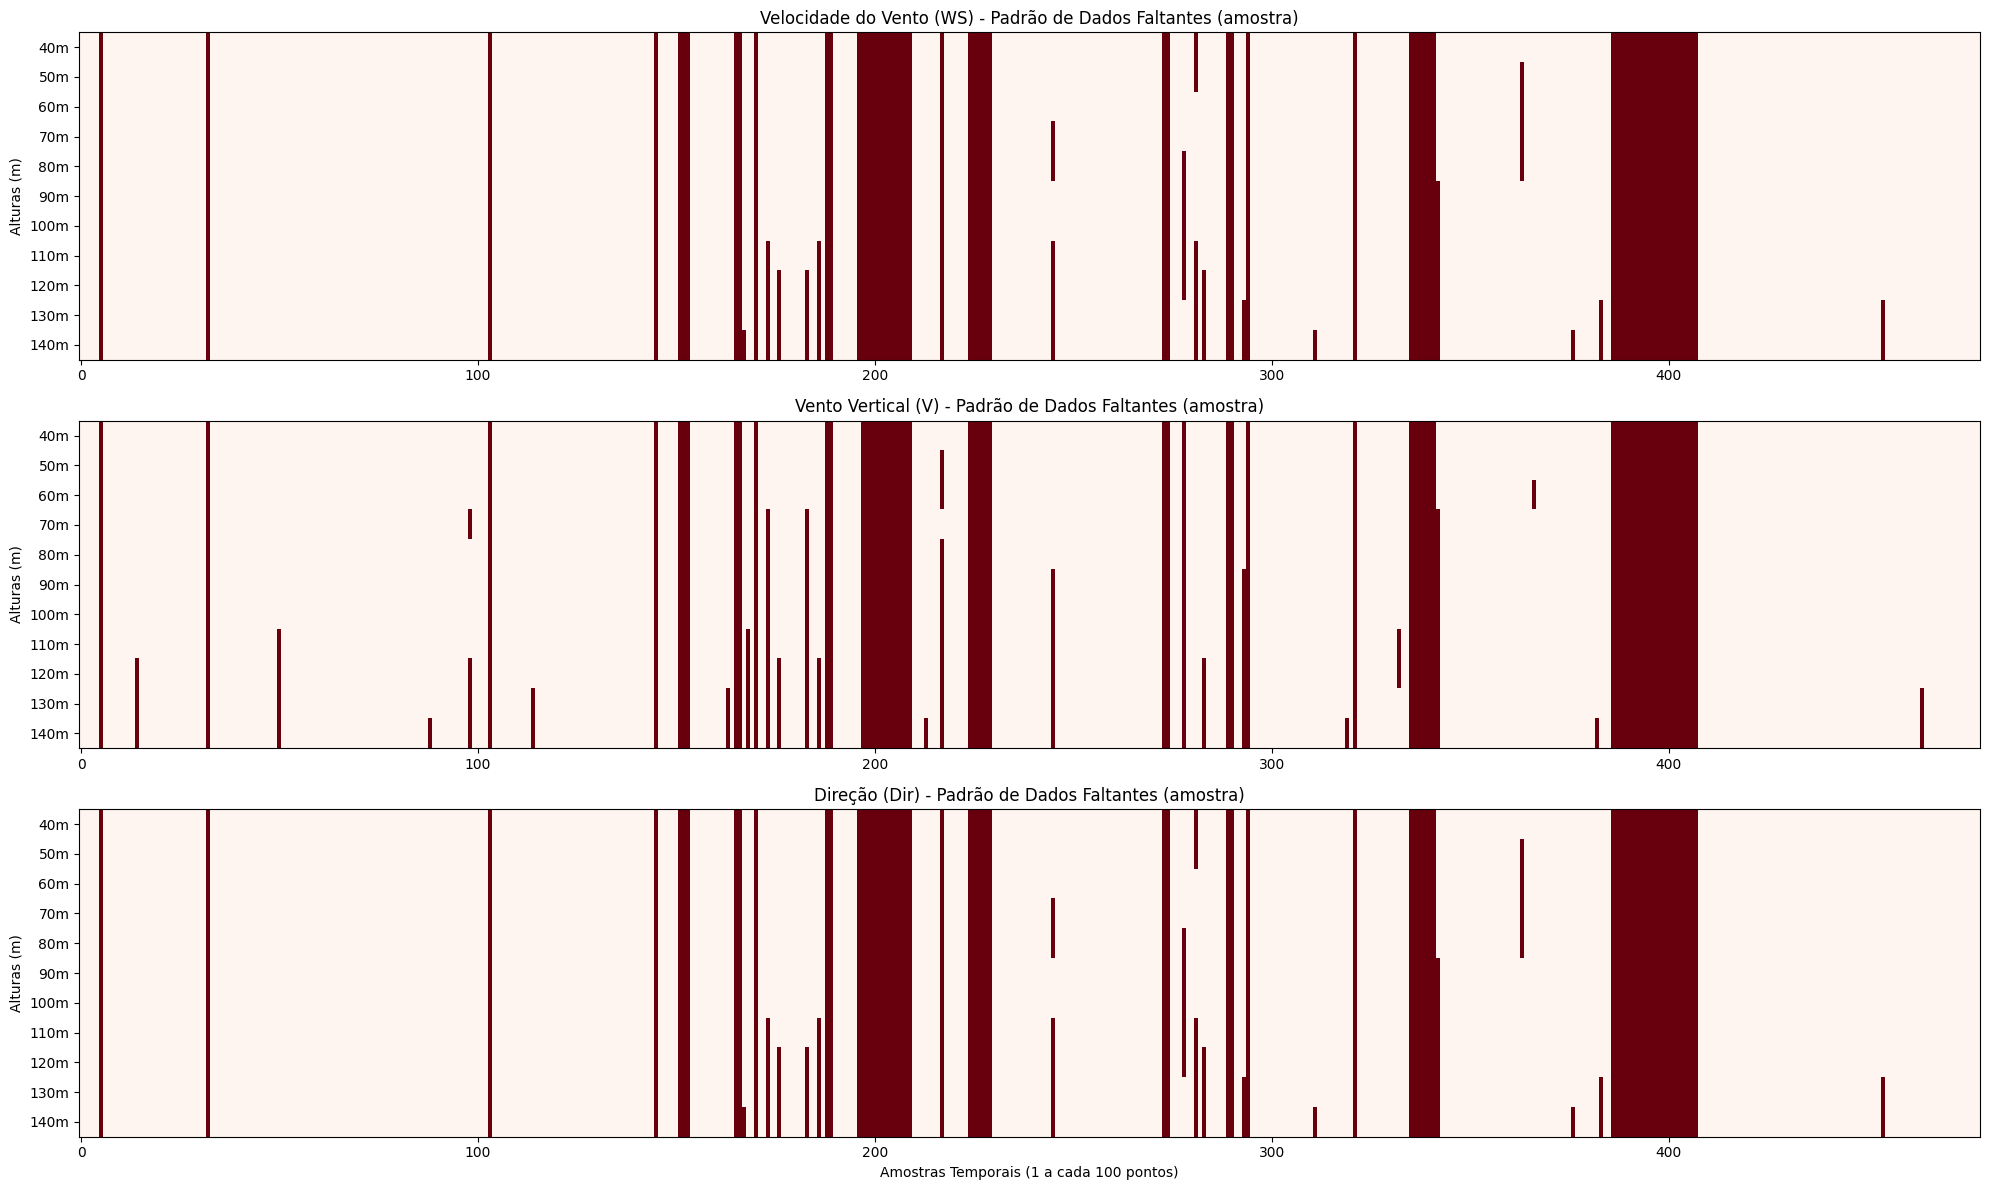


=== Estatísticas Gerais ===
Total de células: 1,580,700
Células faltantes: 233,444
Completude geral: 85.23%


In [29]:
# Visualizar padrão de dados faltantes
fig, axes = plt.subplots(3, 1, figsize=(20, 12))

# Heatmap de dados faltantes para cada tipo de variável
variable_types = [
    ('Velocidade do Vento (WS)', ws_columns),
    ('Vento Vertical (V)', v_columns),
    ('Direção (Dir)', dir_columns)
]

for i, (title, columns) in enumerate(variable_types):
    # Criar matriz de valores faltantes (1 = faltante, 0 = presente)
    missing_matrix = df[columns].isnull().astype(int)
    
    # Plotar apenas uma amostra para visualização (cada 100º ponto)
    sample_indices = range(0, len(missing_matrix), 100)
    sample_matrix = missing_matrix.iloc[sample_indices]
    
    im = axes[i].imshow(sample_matrix.T, aspect='auto', cmap='Reds', interpolation='nearest')
    axes[i].set_title(f'{title} - Padrão de Dados Faltantes (amostra)')
    axes[i].set_ylabel('Alturas (m)')
    axes[i].set_yticks(range(len(columns)))
    axes[i].set_yticklabels([col.replace('ws', '').replace('v', '').replace('dir', '') + 'm' for col in columns])
    
    if i == 2:  # Último subplot
        axes[i].set_xlabel('Amostras Temporais (1 a cada 100 pontos)')

plt.tight_layout()
plt.show()

# Estatísticas gerais de completude
total_cells = df.size
missing_cells = df.isnull().sum().sum()
completeness = (total_cells - missing_cells) / total_cells * 100

print(f"\n=== Estatísticas Gerais ===")
print(f"Total de células: {total_cells:,}")
print(f"Células faltantes: {missing_cells:,}")
print(f"Completude geral: {completeness:.2f}%")

## 2. Classe de Imputação Multi-Variável

In [30]:
class MultiVariableWindGapFiller:
    """
    Classe para imputação inteligente de gaps em múltiplas variáveis de vento
    """
    
    def __init__(self, dataframe):
        self.original_data = dataframe.copy()
        self.filled_data = dataframe.copy()
        
        # Criar DataFrames para scores de confiança e métodos
        self.confidence_scores = pd.DataFrame(index=dataframe.index, columns=dataframe.columns, dtype=float)
        self.fill_methods = pd.DataFrame(index=dataframe.index, columns=dataframe.columns, dtype=str)
        
        # Inicializar scores: 1.0 para dados originais, NaN para faltantes
        for col in dataframe.columns:
            self.confidence_scores[col] = dataframe[col].notna().astype(float)
            self.fill_methods[col] = dataframe[col].notna().map({True: 'original', False: np.nan})
    
    def identify_gaps(self, series):
        """
        Identifica gaps em uma série temporal
        """
        is_missing = series.isna()
        if not is_missing.any():
            return []
        
        missing_diff = is_missing.astype(int).diff().fillna(0)
        gap_starts = series.index[missing_diff == 1].tolist()
        gap_ends = series.index[missing_diff == -1].tolist()
        
        # Ajustar se começar ou terminar com NaN
        if is_missing.iloc[0]:
            gap_starts.insert(0, series.index[0])
        if is_missing.iloc[-1]:
            gap_ends.append(series.index[-1])
        
        gaps = []
        for start, end in zip(gap_starts, gap_ends):
            duration_hours = (end - start).total_seconds() / 3600
            gaps.append({
                'start': start,
                'end': end,
                'duration_hours': duration_hours
            })
        
        return gaps
    
    def kalman_filter_1d(self, observations, initial_state=None, process_variance=1e-5, observation_variance=1e-1):
        """
        Filtro de Kalman 1D simples para suavização de séries temporais
        """
        n = len(observations)
        
        # Arrays para armazenar estimativas
        x_hat = np.zeros(n)  # estimativa a posteriori
        P = np.zeros(n)      # covariância a posteriori
        x_hat_minus = np.zeros(n)  # estimativa a priori
        P_minus = np.zeros(n)      # covariância a priori
        K = np.zeros(n)      # ganho de Kalman
        
        # Inicialização
        if initial_state is not None:
            x_hat[0] = initial_state
        else:
            # Usar primeiro valor válido como estado inicial
            valid_mask = ~np.isnan(observations)
            if valid_mask.any():
                x_hat[0] = observations[valid_mask][0]
            else:
                x_hat[0] = 0
        
        P[0] = 1.0
        
        for k in range(1, n):
            # Predição
            x_hat_minus[k] = x_hat[k-1]
            P_minus[k] = P[k-1] + process_variance
            
            # Atualização
            if not np.isnan(observations[k]):
                # Temos observação
                K[k] = P_minus[k] / (P_minus[k] + observation_variance)
                x_hat[k] = x_hat_minus[k] + K[k] * (observations[k] - x_hat_minus[k])
                P[k] = (1 - K[k]) * P_minus[k]
            else:
                # Sem observação, usar predição
                x_hat[k] = x_hat_minus[k]
                P[k] = P_minus[k]
        
        return x_hat
    
    def fill_short_gaps(self, column, max_hours=6):
        """
        Preenche gaps curtos (≤6h) usando interpolação + Kalman
        """
        series = self.filled_data[column].copy()
        gaps = self.identify_gaps(series)
        short_gaps = [g for g in gaps if g['duration_hours'] <= max_hours]
        
        filled_count = 0
        
        for gap in short_gaps:
            try:
                # Obter contexto ao redor do gap (±12h)
                context_start = max(gap['start'] - pd.Timedelta(hours=12), series.index[0])
                context_end = min(gap['end'] + pd.Timedelta(hours=12), series.index[-1])
                
                # Garantir que temos índices válidos
                context_start_idx = series.index.get_loc(context_start, method='nearest')
                context_end_idx = series.index.get_loc(context_end, method='nearest')
                
                context_data = series.iloc[context_start_idx:context_end_idx+1]
                
                if len(context_data) < 3:
                    continue
                
                # Primeira etapa: interpolação linear
                interpolated = context_data.interpolate(method='linear', limit_direction='both')
                
                # Segunda etapa: Filtro de Kalman para suavização
                kalman_smoothed = self.kalman_filter_1d(interpolated.values)
                interpolated_kalman = pd.Series(kalman_smoothed, index=interpolated.index)
                
                # Aplicar valores apenas no gap
                gap_start_idx = series.index.get_loc(gap['start'], method='nearest')
                gap_end_idx = series.index.get_loc(gap['end'], method='nearest')
                gap_range = series.index[gap_start_idx:gap_end_idx+1]
                
                # Filtrar apenas índices que estão realmente no gap e no contexto
                valid_gap_range = gap_range.intersection(interpolated_kalman.index)
                
                if len(valid_gap_range) > 0:
                    self.filled_data.loc[valid_gap_range, column] = interpolated_kalman.loc[valid_gap_range]
                    
                    # Definir confiança e método
                    self.confidence_scores.loc[valid_gap_range, column] = 0.85
                    self.fill_methods.loc[valid_gap_range, column] = 'interpolation_kalman'
                    
                    filled_count += len(valid_gap_range)
                
            except Exception as e:
                print(f"Erro ao preencher gap curto em {column} ({gap['start']}): {e}")
        
        return filled_count
    
    def calculate_seasonal_statistics(self, series):
        """
        Calcula estatísticas sazonais para uma série
        """
        valid_data = series.dropna()
        
        if len(valid_data) == 0:
            return None
        
        # Padrões diários (dia do ano)
        daily_means = valid_data.groupby(valid_data.index.dayofyear).mean().to_dict()
        
        # Fatores horários normalizados
        hourly_means = valid_data.groupby(valid_data.index.hour).mean()
        overall_mean = valid_data.mean()
        
        if overall_mean == 0:
            hourly_factors = {h: 1.0 for h in range(24)}
        else:
            hourly_factors = (hourly_means / overall_mean).to_dict()
        
        # Desvios padrão horários
        hourly_std = valid_data.groupby(valid_data.index.hour).std().fillna(valid_data.std()).to_dict()
        
        return {
            'daily_means': daily_means,
            'hourly_factors': hourly_factors,
            'hourly_std': hourly_std,
            'overall_mean': overall_mean,
            'overall_std': valid_data.std()
        }
    
    def fill_long_gaps(self, column, random_state=None):
        """
        Preenche gaps longos (>6h) usando modelo sazonal avançado
        Adaptado do método fill_long_gaps original
        """
        series = self.filled_data[column].copy()
        gaps = self.identify_gaps(series)
        long_gaps = [g for g in gaps if g['duration_hours'] > 6]
        
        if not long_gaps:
            return 0
        
        stats = self.calculate_seasonal_statistics(series)
        if stats is None:
            return 0
        
        rng = np.random.default_rng(random_state)
        filled_total = 0
        
        # Vetores de fatores
        hourly_vec = np.array([stats['hourly_factors'].get(h, 1.0) for h in range(24)])
        hourly_std_vec = np.array([stats['hourly_std'].get(h, stats['overall_std']) for h in range(24)])
        
        daily_mean = stats['daily_means']
        overall_mean = stats['overall_mean']
        overall_std = stats['overall_std']
        
        for gap in long_gaps:
            try:
                idx = pd.date_range(gap['start'], gap['end'], freq='10min')
                idx = idx.intersection(self.filled_data.index)
                if idx.empty:
                    continue
                
                doy = idx.dayofyear.to_numpy()
                hr = idx.hour.to_numpy()
                
                mu_day = np.array([daily_mean.get(d, overall_mean) for d in doy])
                base = mu_day * hourly_vec[hr]
                
                sigma = np.maximum(hourly_std_vec[hr], overall_std * 0.1)
                
                # Ruído AR(1) para suavidade temporal
                phi = 0.85
                eps = rng.normal(0, sigma)
                noise = np.empty_like(base)
                noise[0] = eps[0] if len(eps) > 0 else 0
                coef = np.sqrt(1 - phi ** 2)
                for t in range(1, len(base)):
                    if t < len(eps):
                        noise[t] = phi * noise[t - 1] + eps[t] * coef
                    else:
                        noise[t] = phi * noise[t - 1]
                
                values = np.clip(base + noise, a_min=0, a_max=None)
                
                # Blending adaptativo nas bordas
                max_blend = 72  # máx. 12h
                edge_len = int(min(max_blend, max(12, gap['duration_hours'] * 6)))
                
                if (len(values) > 2 * edge_len and 
                    (idx[0] - pd.Timedelta(minutes=10)) in self.filled_data.index and
                    (idx[-1] + pd.Timedelta(minutes=10)) in self.filled_data.index):
                    
                    w = np.linspace(0, 1, edge_len)
                    prev = self.filled_data.loc[idx[0] - pd.Timedelta(minutes=10), column]
                    next_ = self.filled_data.loc[idx[-1] + pd.Timedelta(minutes=10), column]
                    
                    if not (np.isnan(prev) or np.isnan(next_)):
                        values[:edge_len] = prev * (1 - w) + values[:edge_len] * w
                        values[-edge_len:] = next_ * w[::-1] + values[-edge_len:] * (1 - w[::-1])
                
                # Suavização opcional
                try:
                    from scipy.signal import savgol_filter
                    if len(values) >= 21:
                        values = savgol_filter(values, 21, 3, mode='interp')
                except Exception:
                    values = pd.Series(values, index=idx).rolling(window=9, center=True, min_periods=1).mean().to_numpy()
                
                # Aplicar valores
                self.filled_data.loc[idx, column] = values
                
                # Confiança com perfil logístico
                x = np.linspace(-2, 2, len(idx))
                edge_profile = 1 - 1 / (1 + np.exp(-x))
                size_penalty = np.clip(1 - gap['duration_hours'] / (30 * 24), 0.2, 0.8)
                conf = 0.2 + 0.6 * edge_profile * size_penalty
                
                self.confidence_scores.loc[idx, column] = conf
                self.fill_methods.loc[idx, column] = 'seasonal_model'
                
                filled_total += len(idx)
                
            except Exception as e:
                print(f"Erro ao preencher gap longo em {column} ({gap['start']}): {e}")
        
        return filled_total
    
    def process_all_columns(self, random_state=42):
        """
        Processa todas as colunas do dataset
        """
        results = {
            'short_gaps_filled': {},
            'long_gaps_filled': {},
            'total_filled': {}
        }
        
        print(f"=== Iniciando Imputação de {len(self.original_data.columns)} Variáveis ===")
        
        for i, column in enumerate(self.original_data.columns, 1):
            print(f"\nProcessando {i}/{len(self.original_data.columns)}: {column}")
            
            # Contar valores faltantes iniciais
            initial_missing = self.filled_data[column].isna().sum()
            
            if initial_missing == 0:
                print(f"  ✓ Sem valores faltantes")
                results['short_gaps_filled'][column] = 0
                results['long_gaps_filled'][column] = 0
                results['total_filled'][column] = 0
                continue
            
            print(f"  Valores faltantes: {initial_missing:,} ({initial_missing/len(self.filled_data)*100:.1f}%)")
            
            # Preencher gaps curtos
            short_filled = self.fill_short_gaps(column, max_hours=6)
            
            # Preencher gaps longos
            long_filled = self.fill_long_gaps(column, random_state=random_state)
            
            total_filled = short_filled + long_filled
            final_missing = self.filled_data[column].isna().sum()
            
            results['short_gaps_filled'][column] = short_filled
            results['long_gaps_filled'][column] = long_filled
            results['total_filled'][column] = total_filled
            
            print(f"  ✓ Gaps curtos preenchidos: {short_filled:,}")
            print(f"  ✓ Gaps longos preenchidos: {long_filled:,}")
            print(f"  ✓ Total preenchido: {total_filled:,}")
            print(f"  ✓ Ainda faltantes: {final_missing:,}")
        
        return results
    
    def get_results(self):
        """
        Retorna resultados da imputação
        """
        return {
            'filled_data': self.filled_data,
            'confidence_scores': self.confidence_scores,
            'fill_methods': self.fill_methods,
            'original_data': self.original_data
        }

print("✓ Classe MultiVariableWindGapFiller implementada com Filtro de Kalman")

✓ Classe MultiVariableWindGapFiller implementada com Filtro de Kalman


## 3. Aplicar Imputação em Todas as Variáveis

In [31]:
# Inicializar o sistema de imputação
print("=== Inicializando Sistema de Imputação ===")
gap_filler = MultiVariableWindGapFiller(df)

# Estatísticas iniciais
initial_stats = {
    'total_cells': df.size,
    'missing_cells': df.isnull().sum().sum(),
    'completeness': (df.size - df.isnull().sum().sum()) / df.size * 100
}

print(f"Estatísticas iniciais:")
print(f"  Total de células: {initial_stats['total_cells']:,}")
print(f"  Células faltantes: {initial_stats['missing_cells']:,}")
print(f"  Completude inicial: {initial_stats['completeness']:.2f}%")

# Aplicar imputação
processing_results = gap_filler.process_all_columns(random_state=42)

=== Inicializando Sistema de Imputação ===
Estatísticas iniciais:
  Total de células: 1,580,700
  Células faltantes: 233,444
  Completude inicial: 85.23%
=== Iniciando Imputação de 33 Variáveis ===

Processando 1/33: ws40
  Valores faltantes: 6,696 (14.0%)
Erro ao preencher gap curto em ws40 (2021-11-13 03:50:00): DatetimeIndex.get_loc() got an unexpected keyword argument 'method'
Erro ao preencher gap curto em ws40 (2021-11-14 03:10:00): DatetimeIndex.get_loc() got an unexpected keyword argument 'method'
Erro ao preencher gap curto em ws40 (2021-11-14 04:20:00): DatetimeIndex.get_loc() got an unexpected keyword argument 'method'
Erro ao preencher gap curto em ws40 (2021-11-14 07:10:00): DatetimeIndex.get_loc() got an unexpected keyword argument 'method'
Erro ao preencher gap curto em ws40 (2021-11-14 09:10:00): DatetimeIndex.get_loc() got an unexpected keyword argument 'method'
Erro ao preencher gap curto em ws40 (2021-11-18 04:40:00): DatetimeIndex.get_loc() got an unexpected keyword

In [32]:
# Obter resultados finais
results = gap_filler.get_results()
filled_data = results['filled_data']
confidence_scores = results['confidence_scores']
fill_methods = results['fill_methods']

# Estatísticas finais
final_stats = {
    'total_cells': filled_data.size,
    'missing_cells': filled_data.isnull().sum().sum(),
    'completeness': (filled_data.size - filled_data.isnull().sum().sum()) / filled_data.size * 100
}

print(f"\n=== Resumo Final da Imputação ===")
print(f"Estatísticas finais:")
print(f"  Total de células: {final_stats['total_cells']:,}")
print(f"  Células ainda faltantes: {final_stats['missing_cells']:,}")
print(f"  Completude final: {final_stats['completeness']:.2f}%")

# Calcular totais por método
total_short_filled = sum(processing_results['short_gaps_filled'].values())
total_long_filled = sum(processing_results['long_gaps_filled'].values())
total_filled = sum(processing_results['total_filled'].values())

print(f"\nResumo por método:")
print(f"  Interpolação (≤6h): {total_short_filled:,} células")
print(f"  Modelo sazonal (>6h): {total_long_filled:,} células")
print(f"  Total imputado: {total_filled:,} células")
print(f"  Melhoria na completude: {final_stats['completeness'] - initial_stats['completeness']:.2f} pontos percentuais")


=== Resumo Final da Imputação ===
Estatísticas finais:
  Total de células: 1,580,700
  Células ainda faltantes: 31,825
  Completude final: 97.99%

Resumo por método:
  Interpolação (≤6h): 0 células
  Modelo sazonal (>6h): 202,150 células
  Total imputado: 202,150 células
  Melhoria na completude: 12.76 pontos percentuais


## 4. Análise de Qualidade da Imputação

In [33]:
# Análise de confiança por tipo de variável
confidence_analysis = {}

variable_groups = {
    'Velocidade (WS)': ws_columns,
    'Vento Vertical (V)': v_columns,
    'Direção (Dir)': dir_columns
}

for group_name, columns in variable_groups.items():
    group_confidence = confidence_scores[columns]
    confidence_analysis[group_name] = {
        'mean_confidence': group_confidence.mean().mean(),
        'min_confidence': group_confidence.min().min(),
        'high_confidence_pct': (group_confidence > 0.8).sum().sum() / group_confidence.size * 100,
        'medium_confidence_pct': ((group_confidence > 0.5) & (group_confidence <= 0.8)).sum().sum() / group_confidence.size * 100,
        'low_confidence_pct': (group_confidence <= 0.5).sum().sum() / group_confidence.size * 100
    }

print("=== Análise de Confiança por Tipo de Variável ===")
for group_name, stats in confidence_analysis.items():
    print(f"\n{group_name}:")
    print(f"  Confiança média: {stats['mean_confidence']:.3f}")
    print(f"  Confiança mínima: {stats['min_confidence']:.3f}")
    print(f"  Alta confiança (>0.8): {stats['high_confidence_pct']:.1f}%")
    print(f"  Média confiança (0.5-0.8): {stats['medium_confidence_pct']:.1f}%")
    print(f"  Baixa confiança (≤0.5): {stats['low_confidence_pct']:.1f}%")

# Análise por método de preenchimento - CORRIGIDA
method_stats = {}
for method in ['original', 'interpolation_kalman', 'seasonal_model']:
    method_mask = fill_methods == method
    method_count = method_mask.sum().sum()
    method_pct = method_count / fill_methods.size * 100
    
    if method_count > 0:
        # Corrigir o cálculo da confiança média - converter para numpy array primeiro
        method_confidence_values = confidence_scores.values[method_mask.values]
        # Filtrar apenas valores não-NaN e calcular média
        valid_confidence = method_confidence_values[~np.isnan(method_confidence_values)]
        if len(valid_confidence) > 0:
            avg_confidence = float(np.mean(valid_confidence))
        else:
            avg_confidence = 0.0
            
        method_stats[method] = {
            'count': method_count,
            'percentage': method_pct,
            'avg_confidence': avg_confidence
        }

print(f"\n=== Análise por Método de Preenchimento ===")
for method, stats in method_stats.items():
    method_display = method.capitalize().replace('_', ' + ')
    print(f"{method_display}:")
    print(f"  Células: {stats['count']:,} ({stats['percentage']:.1f}%)")
    print(f"  Confiança média: {stats['avg_confidence']:.3f}")

=== Análise de Confiança por Tipo de Variável ===

Velocidade (WS):
  Confiança média: 0.905
  Confiança mínima: 0.000
  Alta confiança (>0.8): 85.4%
  Média confiança (0.5-0.8): 2.9%
  Baixa confiança (≤0.5): 11.8%

Vento Vertical (V):
  Confiança média: 0.901
  Confiança mínima: 0.000
  Alta confiança (>0.8): 84.9%
  Média confiança (0.5-0.8): 2.9%
  Baixa confiança (≤0.5): 12.2%

Direção (Dir):
  Confiança média: 0.905
  Confiança mínima: 0.000
  Alta confiança (>0.8): 85.4%
  Média confiança (0.5-0.8): 2.9%
  Baixa confiança (≤0.5): 11.8%



=== Análise por Método de Preenchimento ===
Original:
  Células: 1,346,725 (85.2%)
  Confiança média: 1.000
Seasonal + model:
  Células: 202,150 (12.8%)
  Confiança média: 0.403


## 5. Visualização dos Resultados

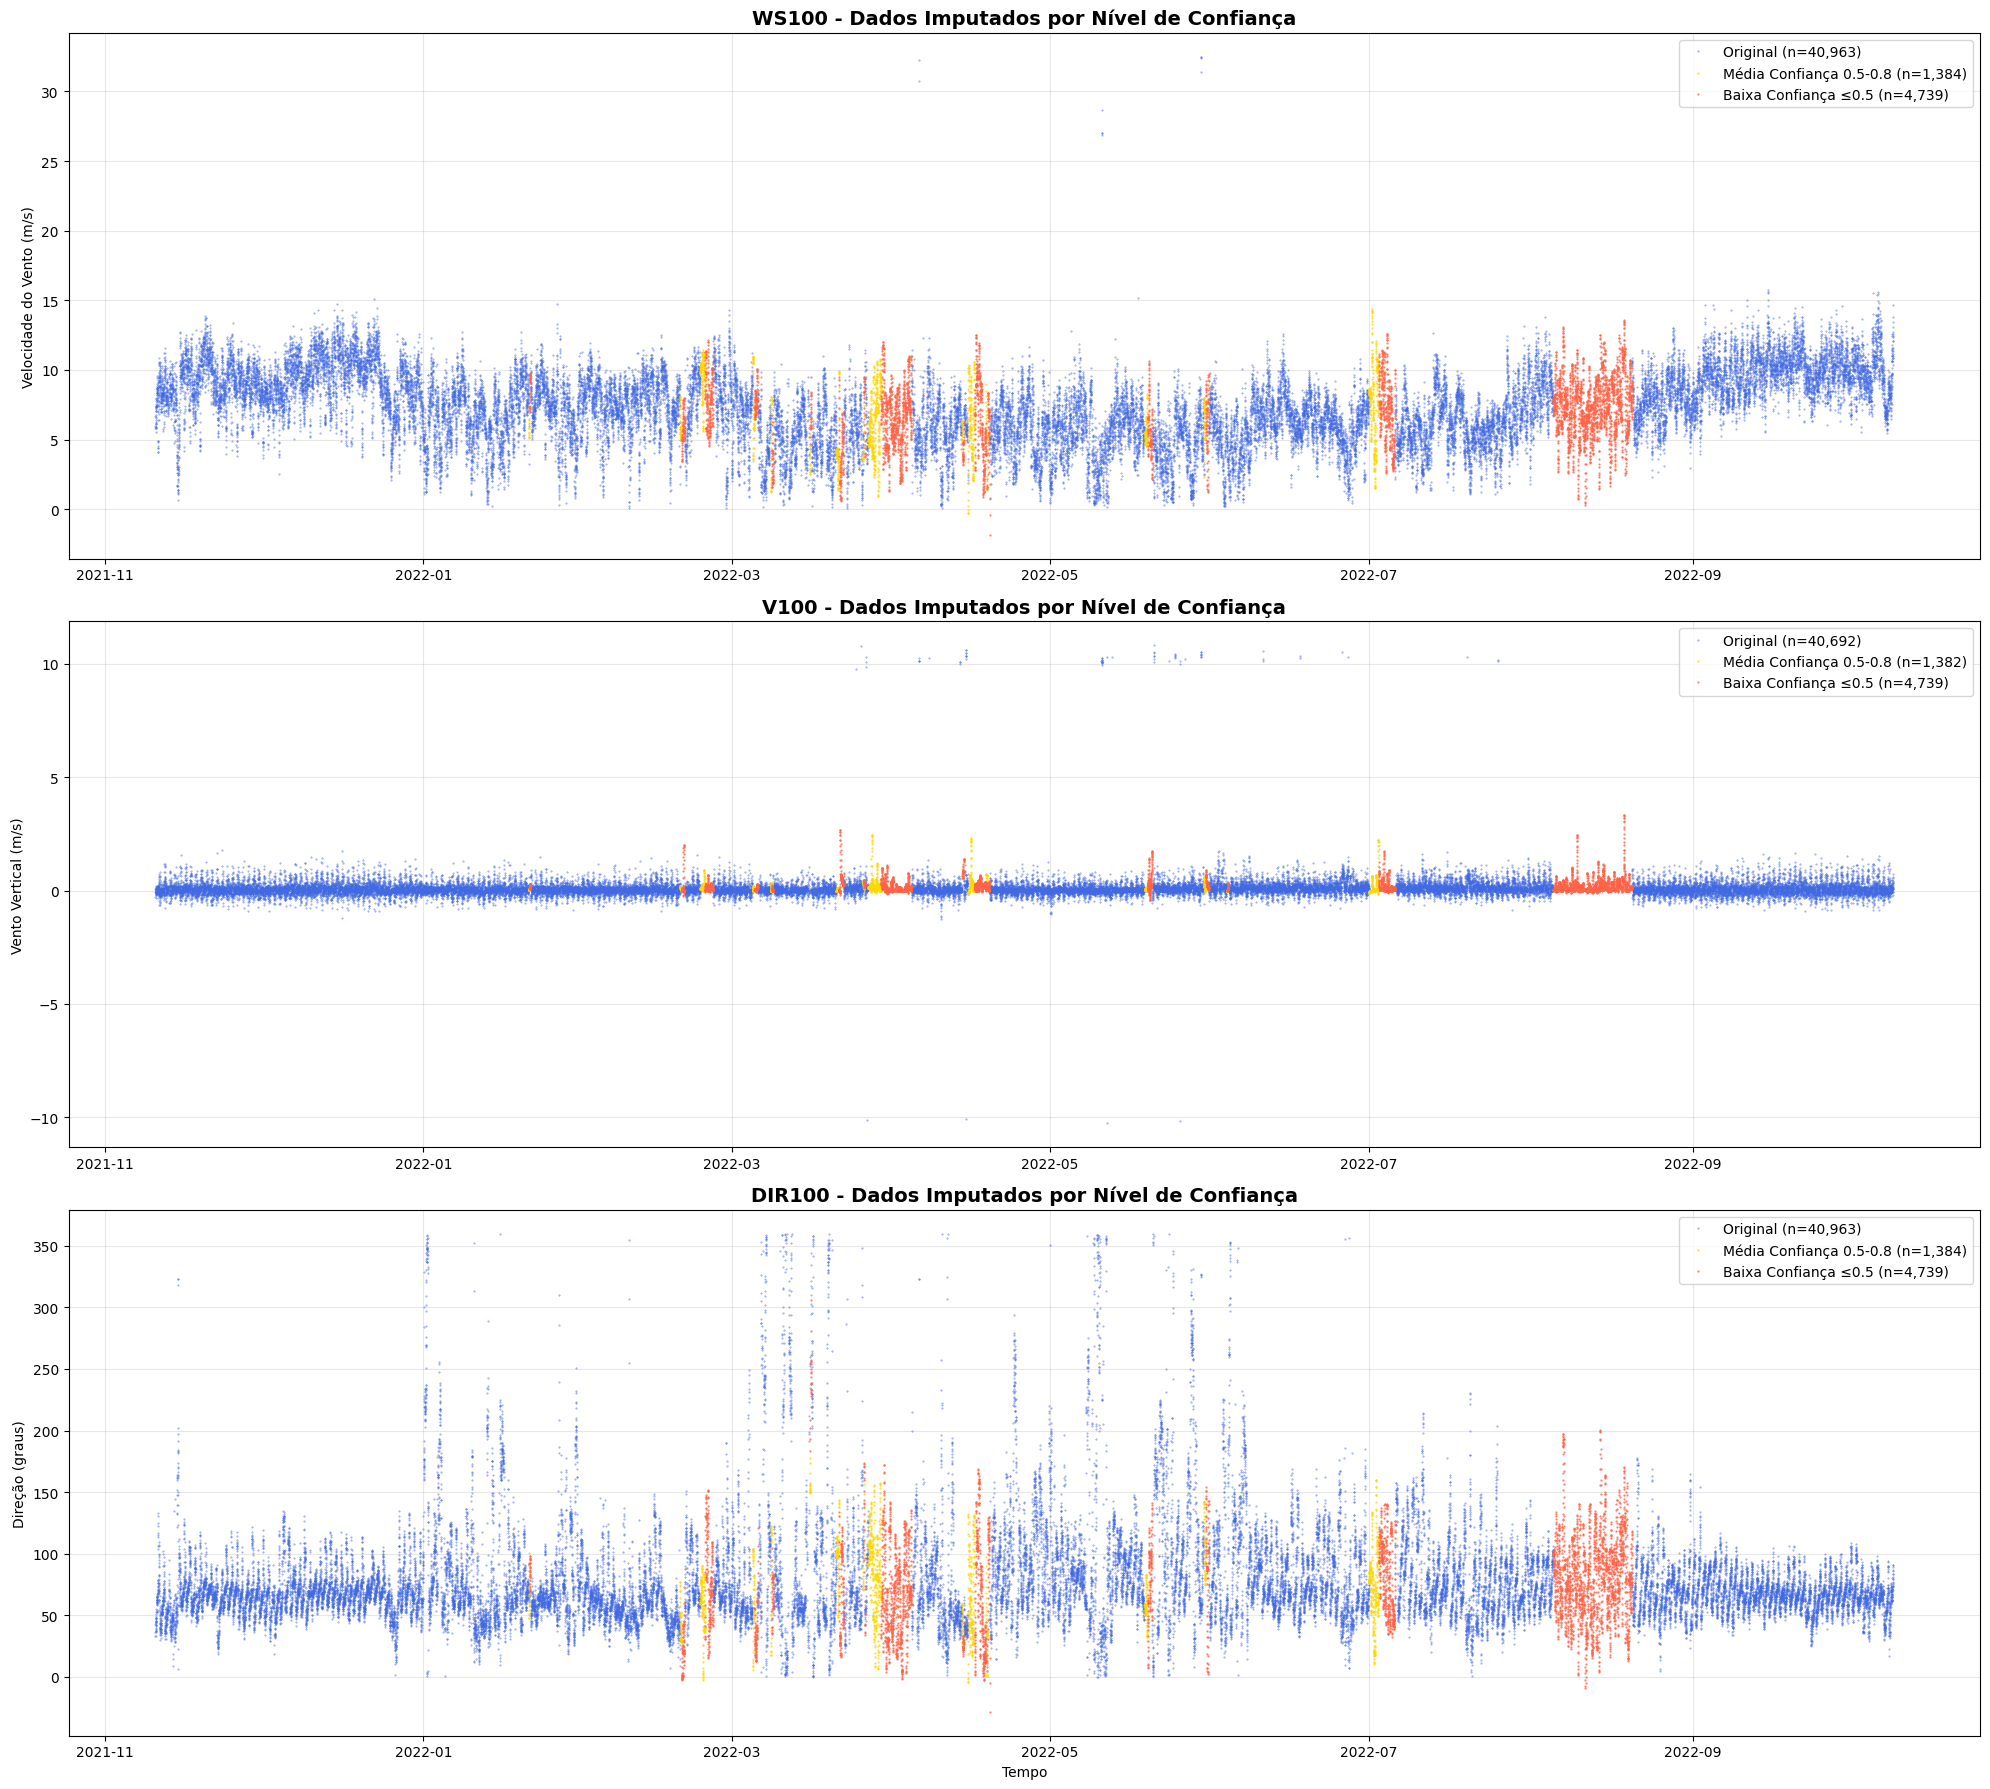


=== Visualização Gerada ===
Variáveis mostradas: ws100, v100, dir100
Período: 2021-11-10 17:20:00 até 2022-10-09 08:30:00
Total de pontos por variável: 47,900


In [34]:
# Função para retornar unidades apropriadas
def get_unit_label(variable):
    """Retorna a unidade apropriada para cada tipo de variável"""
    if variable.startswith('ws'):
        return 'Velocidade do Vento (m/s)'
    elif variable.startswith('v'):
        return 'Vento Vertical (m/s)'
    elif variable.startswith('dir'):
        return 'Direção (graus)'
    return 'Valor'

# Criar visualização colorida por confiança para variáveis selecionadas
selected_variables = ['ws100', 'v100', 'dir100']  # Variáveis a 100m como exemplo

fig, axes = plt.subplots(len(selected_variables), 1, figsize=(20, 6*len(selected_variables)))
if len(selected_variables) == 1:
    axes = [axes]

# Definir mapa de cores para confiança
confidence_colors = {
    'high': '#2E8B57',     # Verde escuro para alta confiança (>0.8)
    'medium': '#FFD700',   # Dourado para média confiança (0.5-0.8)
    'low': '#FF6347',      # Vermelho para baixa confiança (≤0.5)
    'original': '#4169E1'  # Azul para dados originais
}

for i, var in enumerate(selected_variables):
    # Verificar se a variável existe
    if var not in filled_data.columns:
        print(f"Variável {var} não encontrada no dataset")
        continue
        
    # Obter dados da variável
    var_data = filled_data[var]
    var_confidence = confidence_scores[var]
    
    # Classificar por nível de confiança
    original_mask = var_confidence == 1.0
    high_conf_mask = (var_confidence > 0.8) & (var_confidence < 1.0)
    medium_conf_mask = (var_confidence > 0.5) & (var_confidence <= 0.8)
    low_conf_mask = (var_confidence <= 0.5) & (var_confidence > 0.0)
    
    # Plotar cada categoria com cor diferente
    if original_mask.any():
        axes[i].plot(var_data.index[original_mask], var_data[original_mask], 
                    '.', color=confidence_colors['original'], alpha=0.7, markersize=0.8, 
                    label=f'Original (n={original_mask.sum():,})')
    
    if high_conf_mask.any():
        axes[i].plot(var_data.index[high_conf_mask], var_data[high_conf_mask], 
                    '.', color=confidence_colors['high'], alpha=0.8, markersize=1.2, 
                    label=f'Alta Confiança >0.8 (n={high_conf_mask.sum():,})')
    
    if medium_conf_mask.any():
        axes[i].plot(var_data.index[medium_conf_mask], var_data[medium_conf_mask], 
                    '.', color=confidence_colors['medium'], alpha=0.8, markersize=1.2, 
                    label=f'Média Confiança 0.5-0.8 (n={medium_conf_mask.sum():,})')
    
    if low_conf_mask.any():
        axes[i].plot(var_data.index[low_conf_mask], var_data[low_conf_mask], 
                    '.', color=confidence_colors['low'], alpha=0.8, markersize=1.2, 
                    label=f'Baixa Confiança ≤0.5 (n={low_conf_mask.sum():,})')
    
    # Configurar gráfico
    axes[i].set_title(f'{var.upper()} - Dados Imputados por Nível de Confiança', 
                     fontsize=14, fontweight='bold')
    axes[i].set_ylabel(get_unit_label(var))
    axes[i].legend(loc='upper right', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    
    if i == len(selected_variables) - 1:
        axes[i].set_xlabel('Tempo')

plt.tight_layout()
plt.show()

print(f"\n=== Visualização Gerada ===")
print(f"Variáveis mostradas: {', '.join(selected_variables)}")
print(f"Período: {filled_data.index[0]} até {filled_data.index[-1]}")
print(f"Total de pontos por variável: {len(filled_data):,}")

## 6. Preparar Dataset com Scores de Confiança

In [35]:
# Criar dataset final com dados imputados e scores de confiança
final_dataset = filled_data.copy()

# Adicionar colunas de score de confiança
for col in filled_data.columns:
    score_col = f"{col}_score"
    final_dataset[score_col] = confidence_scores[col]

# Reorganizar colunas para melhor visualização
# Agrupar dados e scores por tipo de variável
organized_columns = []

# Velocidade do vento e seus scores
for col in ws_columns:
    organized_columns.extend([col, f"{col}_score"])

# Vento vertical e seus scores
for col in v_columns:
    organized_columns.extend([col, f"{col}_score"])

# Direção e seus scores
for col in dir_columns:
    organized_columns.extend([col, f"{col}_score"])

final_dataset_organized = final_dataset[organized_columns]

print(f"=== Dataset Final Preparado ===")
print(f"Forma: {final_dataset_organized.shape}")
print(f"Colunas originais: {len(filled_data.columns)}")
print(f"Colunas de score: {len(filled_data.columns)}")
print(f"Total de colunas: {len(final_dataset_organized.columns)}")

# Estatísticas finais de qualidade
print(f"\n=== Estatísticas Finais de Qualidade ===")
overall_confidence = confidence_scores.mean().mean()
high_quality_pct = (confidence_scores > 0.8).sum().sum() / confidence_scores.size * 100
medium_quality_pct = ((confidence_scores > 0.5) & (confidence_scores <= 0.8)).sum().sum() / confidence_scores.size * 100
low_quality_pct = (confidence_scores <= 0.5).sum().sum() / confidence_scores.size * 100

print(f"Confiança média geral: {overall_confidence:.3f}")
print(f"Dados de alta qualidade (>0.8): {high_quality_pct:.1f}%")
print(f"Dados de qualidade média (0.5-0.8): {medium_quality_pct:.1f}%")
print(f"Dados de baixa qualidade (≤0.5): {low_quality_pct:.1f}%")

# Amostra do dataset final
print(f"\n=== Amostra do Dataset Final ===")
print("Primeiras 3 linhas (primeiras 6 colunas):")
print(final_dataset_organized.iloc[:3, :6])

=== Dataset Final Preparado ===
Forma: (47900, 66)
Colunas originais: 33
Colunas de score: 33
Total de colunas: 66

=== Estatísticas Finais de Qualidade ===
Confiança média geral: 0.904
Dados de alta qualidade (>0.8): 85.2%
Dados de qualidade média (0.5-0.8): 2.9%
Dados de baixa qualidade (≤0.5): 11.9%

=== Amostra do Dataset Final ===
Primeiras 3 linhas (primeiras 6 colunas):
                     ws40  ws40_score  ws50  ws50_score  ws60  ws60_score
timestamp                                                                
2021-11-10 17:20:00  5.03         1.0  5.53         1.0  5.54         1.0
2021-11-10 17:30:00  4.94         1.0  5.30         1.0  5.29         1.0
2021-11-10 17:40:00  4.44         1.0  5.96         1.0  5.66         1.0


## 7. Salvar Resultados

In [36]:
# Salvar dataset principal com imputação
output_files = {}

# 1. Dataset completo com dados imputados e scores
main_output = output_dir / "wind_data_imputed_with_scores.csv"
final_dataset_organized.to_csv(main_output)
output_files['complete_with_scores'] = main_output

# 2. Dataset apenas com dados imputados (sem scores)
data_only_output = output_dir / "wind_data_imputed.csv"
filled_data.to_csv(data_only_output)
output_files['data_only'] = data_only_output

# 3. Dataset apenas com scores de confiança
scores_only_output = output_dir / "wind_data_confidence_scores.csv"
confidence_scores.to_csv(scores_only_output)
output_files['scores_only'] = scores_only_output

# 4. Criar versões filtradas por qualidade
quality_versions = {
    'high_quality': final_dataset_organized[confidence_scores.min(axis=1) > 0.8],
    'medium_quality': final_dataset_organized[confidence_scores.min(axis=1) > 0.5],
    'low_quality_excluded': final_dataset_organized[confidence_scores.min(axis=1) > 0.3]
}

for quality_name, quality_data in quality_versions.items():
    if len(quality_data) > 0:
        quality_output = output_dir / f"wind_data_imputed_{quality_name}.csv"
        quality_data.to_csv(quality_output)
        output_files[quality_name] = quality_output

# 5. Salvar metadados da imputação
metadata = {
    'processing_date': datetime.now().isoformat(),
    'original_shape': list(df.shape),
    'final_shape': list(final_dataset_organized.shape),
    'initial_completeness': initial_stats['completeness'],
    'final_completeness': final_stats['completeness'],
    'improvement': final_stats['completeness'] - initial_stats['completeness'],
    'total_cells_filled': total_filled,
    'short_gaps_filled': total_short_filled,
    'long_gaps_filled': total_long_filled,
    'overall_confidence': overall_confidence,
    'quality_distribution': {
        'high_quality_pct': high_quality_pct,
        'medium_quality_pct': medium_quality_pct,
        'low_quality_pct': low_quality_pct
    },
    'variable_groups': {
        'wind_speed': ws_columns,
        'vertical_wind': v_columns,
        'wind_direction': dir_columns
    },
    'imputation_methods': {
        'short_gaps': 'Linear interpolation + Kalman filter (≤6h)',
        'long_gaps': 'Seasonal model with hourly/daily patterns (>6h)'
    }
}

import json
metadata_output = output_dir / "imputation_metadata.json"
with open(metadata_output, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
output_files['metadata'] = metadata_output

# Resumo dos arquivos gerados
print(f"=== Arquivos Gerados ===")
for file_type, filepath in output_files.items():
    size_mb = filepath.stat().st_size / (1024*1024)
    print(f"  {file_type}: {filepath.name} ({size_mb:.2f} MB)")

print(f"\n✓ Todos os arquivos salvos em: {output_dir}")
print(f"✓ Imputação concluída com sucesso!")
print(f"✓ Melhoria na completude: {final_stats['completeness'] - initial_stats['completeness']:.2f} pontos percentuais")
print(f"✓ Confiança média geral: {overall_confidence:.3f}")

=== Arquivos Gerados ===
  complete_with_scores: wind_data_imputed_with_scores.csv (20.13 MB)
  data_only: wind_data_imputed.csv (11.16 MB)
  scores_only: wind_data_confidence_scores.csv (9.88 MB)
  high_quality: wind_data_imputed_high_quality.csv (11.97 MB)
  medium_quality: wind_data_imputed_medium_quality.csv (13.63 MB)
  low_quality_excluded: wind_data_imputed_low_quality_excluded.csv (17.65 MB)
  metadata: imputation_metadata.json (0.00 MB)

✓ Todos os arquivos salvos em: ../imputed_data
✓ Imputação concluída com sucesso!
✓ Melhoria na completude: 12.76 pontos percentuais
✓ Confiança média geral: 0.904


## 8. Recomendações para Uso

### Arquivos Gerados
1. **`wind_data_imputed_with_scores.csv`** - Dataset completo com dados imputados e scores de confiança
2. **`wind_data_imputed.csv`** - Apenas dados imputados (para análises básicas)
3. **`wind_data_confidence_scores.csv`** - Apenas scores de confiança
4. **Versões por qualidade** - Datasets filtrados por nível de confiança

### Estratégia de Uso
- **Machine Learning**: Usar dataset com scores como features adicionais
- **Análises estatísticas**: Ponderar resultados pelos scores de confiança
- **Validação**: Usar apenas dados com score = 1.0 (originais)
- **Treinamento robusto**: Usar dados com score > 0.5

### Interpretação dos Scores
- **1.0**: Dados originais (máxima confiança)
- **0.85**: Gaps curtos imputados (≤6h) - alta confiança
- **0.2-0.8**: Gaps longos imputados (>6h) - confiança variável
- **Perfil logístico**: Bordas dos gaps longos têm maior confiança